# Udacity DRLND Continuous Control



### Algorithm

The choice of algorithm to solve the Unity Reacher environment is [DDPG](https://arxiv.org/abs/1509.02971). 

### Hyperparameters

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.9             # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0001   # L2 weight decay

### Model architecture

For this project, I used a slightly simple neural network, so using GPU does not actually speed up much compared to training on CPU.

Actor-network

| <i></i>  |input units|output units|
|---|---|---|
|input layer|33|128|
|hidden layer|128|128|
|output layer|128|4|

Critic-network

| <i></i>  |input units|output units|
|---|---|---|
|input layer|33|128|
|hidden layer|128+4|128|
|output layer|128|1|

I also add batch normalization layer on most layers except before input and after output layer of Critic-network.

## 1. load the necessary package

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

%aimport  model, test_agents

from test_agents import Agent
from model import Actor, Critic

In [3]:
# file = 'One_agent/Reacher.exe'
file = '20_agents/Reacher.exe'
env = UnityEnvironment(file_name=file)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)
# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)
# examine the state space 
states = env_info.vector_observations
print('states shape: ', states.shape)
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 20
Size of each action: 4
states shape:  (20, 33)


## 2. training control

Due to the long training time, I come up with a simple idea to be able to stop and continue the training without losing any progress. I create a python dictionary called log to store some hyperparameters like total_episodes, etc. Then I use another python script called log_control to check and modify log. To be able to stop the training anytime I want, there is an item whose key called 'end_now', if I want to end the training, I simply call end_now() in log_control.py, then before the next episode, ddpg() will check if it's True, if yes, then ddpg() ends the training right away. 

In [4]:
import pickle
log = {
    'total_episodes': 120, 
    'current_episodes': 0,
    'scores': [], # store the score for every episode
    'save_every': 30,
    'print_every': 30, 
    'end_now': False, # use log_control.py to modify this to end the training before next episode start
    'solved': False,
    'solved_score':30, # score that we consider the environment is solved
    'solve_in_episodes': None
}

import os.path
log_path = 'log.pkl'

def save_log(log_path, log):
    with open(log_path, 'wb') as f: 
        pickle.dump(log, f)
def load_log(log_path):
    with open(log_path, 'rb') as f: 
        log = pickle.load(f)
    return log

# if you need to start over then uncomment the next line
# save_log(log_path, log)

if os.path.exists(log_path):
    log = load_log(log_path)
else:
    save_log(log_path, log)


## 3. Training

Episode 30	Average Score: 4.27	Score: 14.40
Episode 60	Average Score: 19.77	Score: 39.05
Episode 90	Average Score: 26.13	Score: 37.40
Episode 108	Average Score: 30.23	Score: 37.41
environment solved in 108th episodes
Episode 120	Average Score: 34.49	Score: 37.86


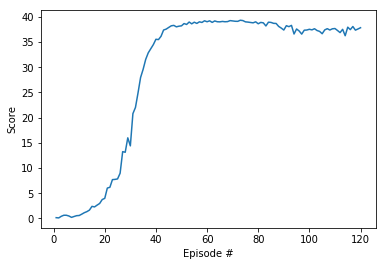

Wall time: 22h 35min 56s


In [5]:
%%time
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, num_process=10,random_seed=0)


def ddpg(max_t=1000, log=log, log_path=log_path):
    # ----------load variables
    total_episodes = log['total_episodes']
    current_episodes = log['current_episodes']
    scores = log['scores']
    save_every = log['save_every']
    print_every = log['print_every']
    solved = log['solved']
    solved_score = log['solved_score']
    scores_deque = deque(maxlen=100)

    # ----------load weights and scores_deque if continue training
    if current_episodes != 0:
        agent.load_weights()
        [scores_deque.append(e) for e in scores]

    for i_episode in range(current_episodes + 1, total_episodes + 1):

        # -----check if need to end the training-------
        log = load_log(log_path)
        if log['end_now']:
            log['end_now'] = False
            log['current_episodes'] = i_episode-1 # this episodes hasn't started yet
            save_log(log_path, log)
            agent.save_weights()
            break

        # -----generating state--------
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment    
        states = env_info.vector_observations  # get the current state (for each agent)
        agent.reset()
        score = 0

        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]  # send all actions to tne environment
            next_states = env_info.vector_observations  # get next state (for each agent)
            rewards = env_info.rewards  # get reward (for each agent)
            dones = env_info.local_done  # see if episode finished
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += np.mean(rewards)
            if np.any(dones):
                break
        scores_deque.append(score)
        scores.append(score)

        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        # -----------if solved, store model weights and log------------------
        if np.mean(scores_deque) > solved_score and solved == False:
            print('\nenvironment solved in {}th episodes'.format(i_episode))
            solved = True
            log['solved'] = True
            log['solve_in_episodes'] = i_episode
            agent.save_weights()
            save_log(log_path, log)
            
        # ------------ save progress----------
        if i_episode % save_every == 0 or i_episode == total_episodes:
            log['current_episodes'] = i_episode
            log['scores'] = scores
            save_log(log_path, log)
            agent.save_weights()
#     if np.mean(scores_deque) > solved_score:
#         agent.save_weights()
    return scores


scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 4. Replay

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, num_process=10,random_seed=0)
agent.load_weights()

In [15]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)

    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 38.11249914811924


In [ ]:
env.close()

## 5. Future improve

When first time I ran the 20 agents version of this environment, it took my AMD 12 cores CPU and Nvidia GTX 1080 GPU over three days to run 300 episodes. One of the reason is that I only utilized one CPU core and one GPU. Then I thought, if I can come up a way to utilize more computing power, then I'd be able to try more combinations of hyperparameters in the same amount of the time. Next, I spend the whole week trying to use torch.multiprocessing to utilize multiple cores training the models. In the end, I did it, I spawn 20 subprocesses(`Process(target=agent.learn, ...)`, using Queue() to send them experiences to train. Just one problem, it only works in CPU mode, I was unable to use CUDA. I also tried other methods like sending subprocesses the model_dict() and rebuild the model, train then send back model_dict(), but I still couldn't use CUDA(at least in Windows).

Another parallel package I also tried is ipyparallel, but it still suffers the same problem: you won't be able to use CUDA. However, ipyparallel seems to have more restriction comparing to torch.multiprocessing.

There are some future works for me to explore and improve this project:

1. Modify the 20 subprocesses part, combining subprocesses and threads to consume less resource(20 processes plus training on CPU is too much to handle on my local machine). 
2. Try to run the code under Linux. Some source said the only way to use torch.multiprocessing and CUDA together(torch version <= 0.41) is under Linux.
3. I shouldn't need 20 critics or 20 actors, I can collect 20 actors output then send to one critic to learn. By using one common critic, it should greatly improve learning speed.
4. Implementing D4PG.


